In [1]:
from urbf_layer.incremental_rbf_layer import IncrementalRBFLayer

In [2]:
import torch

in_features = 2
out_features = 16
ranges = [(-30,10), (-1,1)]

dimension_ranges = []

out_features_per_dim = int(out_features ** (1/in_features))

max_step = 0

for i in range(in_features):
    # Calculate the step for each dimension
    #step = (ranges[i][1] - ranges[i][0]) / out_features_per_dim

    # if step > max_step:
    #     max_step = step

    # Create a range of values for this dimension
    dim_range = torch.linspace(ranges[i][0], ranges[i][1], 100)
    dimension_ranges.append(dim_range)

# Use meshgrid to create the grid for all dimensions
grid = torch.meshgrid(*dimension_ranges, indexing='ij')

# Reshape the grid to a 2D tensor
grid = torch.stack(grid).reshape(in_features, -1).T

print(grid.shape)
print(grid)

torch.Size([10000, 2])
tensor([[-30.0000,  -1.0000],
        [-30.0000,  -0.9798],
        [-30.0000,  -0.9596],
        ...,
        [ 10.0000,   0.9596],
        [ 10.0000,   0.9798],
        [ 10.0000,   1.0000]])


In [3]:

def plot_out(out):
    print(f"Layer output: {out.shape}")

    out = out.amax(dim=1)

    data = torch.stack([grid[:,0], grid[:,1], out], dim=1).detach().numpy()

    ## visualize the data in interactive 3D plot
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    ### color code by the output value reduce point size to 1/10th of the default

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(data[:,0], data[:,1], data[:,2], c=data[:,2], cmap='viridis', s=0.4)
    ax.view_init(azim=0, elev=90)
    plt.show()


def plot_layer(layer):
    out = layer(grid)
    plot_out(out)




torch.Size([16, 2, 2])
tensor([[0.0100, 0.0000],
        [0.0000, 4.0000]], grad_fn=<SelectBackward0>)
torch.Size([16, 2])
tensor([[0.0100, 0.0000],
        [0.0000, 4.0000]], grad_fn=<SelectBackward0>)
torch.Size([10000, 2])
x: torch.Size([10000, 2, 16])
m: torch.Size([2, 16])
vars: torch.Size([16, 2, 2])
diag_vars: torch.Size([16, 2]) Parameter containing:
tensor([[0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000]], requires_grad=True)
-> torch.Size([10000, 16, 2, 1])
torch.Size([160000, 2])
torch.Size([160000, 2, 2])
tensor([[0.0100, 0.0000],
        [0.0000, 4.0000]], grad_fn=<SelectBackward0>)
new x: torch.Size([160000])
--> torch.

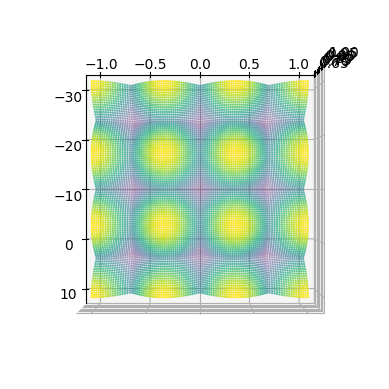

In [4]:
means = torch.rand(in_features, out_features)

out_features_per_dim = int(out_features ** (1/in_features))

# Initialize a list to store the range for each dimension
dimension_ranges = []

steps = torch.zeros(in_features)

for i in range(in_features):
    # Calculate the step for each dimension
    step = (ranges[i][1] - ranges[i][0]) / out_features_per_dim

    steps[i] = step

    # Create a range of values for this dimension
    dim_range = torch.linspace(ranges[i][0], ranges[i][1], out_features_per_dim)
    dimension_ranges.append(dim_range)


steps = steps * steps

# Use meshgrid to create the grid for all dimensions
_grid = torch.meshgrid(*dimension_ranges, indexing='ij')

# Reshape and store the grid points as means
_means = torch.stack([g.flatten() for g in _grid], dim=1).T

means[:,:_means.shape[-1]]= _means

full_vars = torch.nn.Parameter(((torch.zeros(out_features,in_features,in_features) + torch.eye(in_features) * steps)).inverse())

diag_vars = torch.nn.Parameter(torch.div(torch.ones(out_features,in_features),(torch.ones(out_features,in_features) * steps)))


print(full_vars.shape)
print(full_vars[2])

print(diag_vars.shape)
print(torch.diag_embed((diag_vars))[0])

x = grid

print(x.shape)

x = x.unsqueeze(-1).repeat(1,1,out_features)

print(f"x: {x.shape}")
print(f"m: {means.shape}")
print(f"vars: {full_vars.shape}")
print(f"diag_vars: {diag_vars.shape} {diag_vars}")

x = (x - means.repeat(x.shape[0],1,1)).transpose(-1,-2).unsqueeze(-1) ## samples x in_features x out_features

print(f"-> {x.shape}")

full_vars = full_vars.repeat(x.shape[0],1,1)
diag_vars = diag_vars.repeat(x.shape[0],1)

x_size = x.shape


x = x.reshape(-1,x_size[-2])


print(x.shape)
print(full_vars.shape)

print(full_vars[0])

#### since it is a diagonal matrix, we can multiply the diagonal elements with the input vector directly and then sum the result

#x = x.transpose(-1,-2) @ full_vars @ x

x = (x * diag_vars * x).sum(-1)


print(f"new x: {x.shape}")

x = x.reshape(*x_size[0:2])

print(f"--> {x.shape}")

x = torch.exp(-1/2 * x)
x = x.squeeze()

plot_out(x)




Layer output: torch.Size([10000, 16])


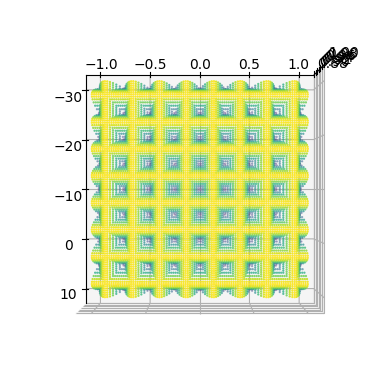

In [5]:
univariate_rbf_layer = IncrementalRBFLayer(in_features, out_features, ranges, complexity="univariate")

plot_layer(univariate_rbf_layer)

initial means: tensor([[-30.0000, -30.0000, -30.0000, -30.0000, -16.6667, -16.6667, -16.6667,
         -16.6667,  -3.3333,  -3.3333,  -3.3333,  -3.3333,  10.0000,  10.0000,
          10.0000,  10.0000],
        [ -1.0000,  -0.3333,   0.3333,   1.0000,  -1.0000,  -0.3333,   0.3333,
           1.0000,  -1.0000,  -0.3333,   0.3333,   1.0000,  -1.0000,  -0.3333,
           0.3333,   1.0000]]) with shape torch.Size([2, 16])
steps: tensor([100.0000,   0.2500])
initial vars: Parameter containing:
tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
       requires_grad=True) with shape torch.Size([16])
mean nans:  tensor(0)  shape:  torch.Size([2, 16])  x nans:  tensor(0)
Layer output: torch.Size([10000, 16])


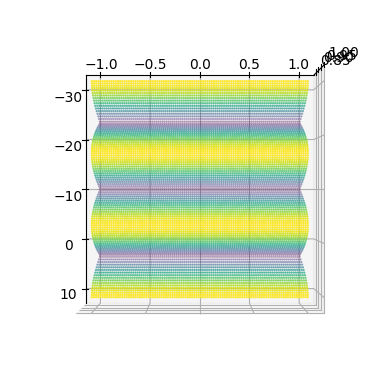

In [6]:
scalar_rbf_layer = IncrementalRBFLayer(in_features, out_features, ranges, complexity="scalar")

plot_layer(scalar_rbf_layer)

initial means: tensor([[-30.0000, -30.0000, -30.0000, -30.0000, -16.6667, -16.6667, -16.6667,
         -16.6667,  -3.3333,  -3.3333,  -3.3333,  -3.3333,  10.0000,  10.0000,
          10.0000,  10.0000],
        [ -1.0000,  -0.3333,   0.3333,   1.0000,  -1.0000,  -0.3333,   0.3333,
           1.0000,  -1.0000,  -0.3333,   0.3333,   1.0000,  -1.0000,  -0.3333,
           0.3333,   1.0000]]) with shape torch.Size([2, 16])
steps: tensor([100.0000,   0.2500])
initial vars: Parameter containing:
tensor([[0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000],
        [0.0100, 4.0000]], requires_grad=True) with shape torch.Size([16, 2])
mean nans:  tensor(0)  shape:  torch.

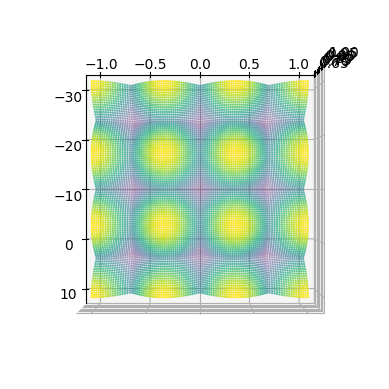

In [7]:
diag_rbf_layer = IncrementalRBFLayer(in_features, out_features, ranges, complexity="diagonal")

plot_layer(diag_rbf_layer)

initial means: tensor([[-30.0000, -30.0000, -30.0000, -30.0000, -16.6667, -16.6667, -16.6667,
         -16.6667,  -3.3333,  -3.3333,  -3.3333,  -3.3333,  10.0000,  10.0000,
          10.0000,  10.0000],
        [ -1.0000,  -0.3333,   0.3333,   1.0000,  -1.0000,  -0.3333,   0.3333,
           1.0000,  -1.0000,  -0.3333,   0.3333,   1.0000,  -1.0000,  -0.3333,
           0.3333,   1.0000]]) with shape torch.Size([2, 16])
steps: tensor([100.0000,   0.2500])
initial vars: Parameter containing:
tensor([[[0.0100, 0.0000],
         [0.0000, 4.0000]],

        [[0.0100, 0.0000],
         [0.0000, 4.0000]],

        [[0.0100, 0.0000],
         [0.0000, 4.0000]],

        [[0.0100, 0.0000],
         [0.0000, 4.0000]],

        [[0.0100, 0.0000],
         [0.0000, 4.0000]],

        [[0.0100, 0.0000],
         [0.0000, 4.0000]],

        [[0.0100, 0.0000],
         [0.0000, 4.0000]],

        [[0.0100, 0.0000],
         [0.0000, 4.0000]],

        [[0.0100, 0.0000],
         [0.0000, 4.0000]],

 

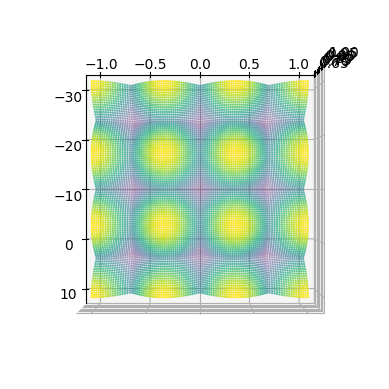

In [8]:
full_rbf_layer = IncrementalRBFLayer(in_features, out_features, ranges, complexity="full")

plot_layer(full_rbf_layer)